## 加载 MNIST 数据集

In [1]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple keras
!pwd
!mkdir -p /root/.keras/datasets/mnist/
!cp /tf/notebooks/chapter-5/mnist/mnist.npz /root/.keras/datasets/mnist/

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
/tf/notebooks/chapter-5


In [2]:
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
# 加载MNIST数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist/mnist.npz')

# 格式
print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))

# 第一个样本
print("x_train[0]:")
for i in range(0, min(3,len(x_train[0]))):
    print(x_train[0][i])
print("...")
print("y_train[0]:")
print(y_train[0])

(60000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>
x_train[0]:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
...
y_train[0]:
5


## 数据处理：规范化

`channels_last` corresponds to inputs with shape  (batch, height, width, channels) while `channels_first` corresponds to inputs with shape  (batch, channels, height, width).

It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be `channels_last`.

In [4]:
# 规范化处理，与MNIST SoftMax不同，用了卷积
# keras支持两种格式（如上面的介绍），channels_last和channels_first
#   channel为1时是灰度图、channel大于1时是用了RGB的图
#   batch指这一批数据有多大，这个例子是60000
# 在～/.keras/keras.json中设置使用哪种（默认是channels_last)
from keras import backend as K

# 图片高度，宽度
img_rows, img_cols = 28, 28

# x_train.shape[0] = 60000 是样本数，如前面的代码
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# re_shape以后的数据集格式
print(x_train.shape, type(x_train))
print(x_test.shape, type(x_test))

# 第一个样本
print("x_train[0]:")
for i in range(0, 28):
    for j in range(0, 28):
        print(x_train[0][i][j][0], end=" ")
    print("")

(60000, 28, 28, 1) <class 'numpy.ndarray'>
(10000, 28, 28, 1) <class 'numpy.ndarray'>
x_train[0]:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 3 18 18 18 126 136 175 26 166 255 247 127 0 0 0 0 
0 0 0 0 0 0 0 0 30 36 94 154 170 253 253 253 253 253 225 172 253 242 195 64 0 0 0 0 
0 0 0 0 0 0 0 49 238 253 253 253 253 253 253 253 253 251 93 82 82 56 39 0 0 0 0 0 
0 0 0 0 0 0 0 18 219 253 253 253 253 253 198 182 247 241 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 80 156 107 253 253 205 11 0 43 154 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 14 1 154 253 90 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 139 253 190 2 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 11 190 253 70 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 35 241 225 

In [5]:
# 对样本特征做归一化处理

# 将数据类型转换为float32
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
# 数据归一化
X_train /= 255
X_test /= 255

# 归一化以后的数据集格式
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# 第一个样本
print("X_train[0]:")
for i in range(0, 28):
    for j in range(0, 28):
        print(X_train[0][i][j][0], end=" ")
    print("")

60000 train samples
10000 test samples
X_train[0]:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.011764706 0.07058824 0.07058824 0.07058824 0.49411765 0.53333336 0.6862745 0.101960786 0.6509804 1.0 0.96862745 0.49803922 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.11764706 0.14117648 0.36862746 0.6039216 0.6666667 0.99215686 0.99215686 0.99215686 0.99215686 0.99215686 0.88235295 0.6745098 0.99215686 0.9490196 0.7647059 0.

## 统计训练数据中各标签数量

In [6]:
# 统计数据中标签的数量，与之前的MNIST SoftMax网络一样
import numpy as np
import matplotlib.pyplot as plt

label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


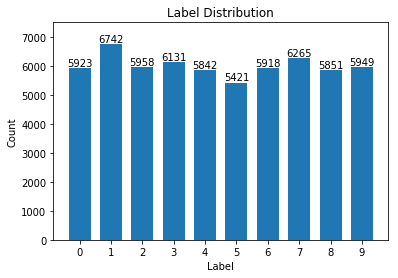

In [7]:
fig = plt.figure()
plt.bar(label, count, width = 0.7, align='center')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(label)
plt.ylim(0,7500)

for a,b in zip(label, count):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()

## 数据处理：one-hot 编码

### 几种编码方式的对比

| Binary | Gray code | One-hot  |
| ------ | --------- | -------- |
| 000    | 000       | 00000001 |
| 001    | 001       | 00000010 |
| 010    | 011       | 00000100 |
| 011    | 010       | 00001000 |
| 100    | 110       | 00010000 |
| 101    | 111       | 00100000 |
| 110    | 101       | 01000000 |
| 111    | 100       | 10000000 |

### one-hot 应用
![](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2018/01/one-hot-word-embedding-vectors.png)

In [8]:
# 对样本标签做one-hot编码
from keras.utils import np_utils

n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)
Y_test = np_utils.to_categorical(y_test, n_classes)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [9]:
# 第一个样本的标签（编码前、编码后）
print(y_train[0])
print(Y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 使用 Keras sequential model 定义 MNIST CNN 网络


In [10]:
# 下面代码用到的一些变量的值
print("input_shape:", input_shape)
print("n_classes:", n_classes)

input_shape: (28, 28, 1)
n_classes: 10


In [11]:
# Sequential Model
from keras.models import Sequential
# Dense：全连接网络层，用于函数拟合
# Dropout：在每一轮训练随机丢弃一些神经元、减少过拟合风险
# Flatten：把 Feature Map 摊平为一阶向量
from keras.layers import Dense, Dropout, Flatten
# Conv2D：2维卷积
# MaxPooling2D： 2维的Pooling，池化
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

### Feature Extraction
# 第1层卷积，32个3x3的卷积核 ，激活函数使用 relu 
# 其实不用单独定义一个激活层，把激活函数作为参数交给卷积层，由框架来自动集成也可以
# input_shape: (28,28,1), 不用考虑样本数60000，只要表示单个样本的shape就行
# 与soft-max不同的是，不需要拉平为长度是784的一阶向量
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))

# 第2层卷积，64个3x3的卷积核，激活函数使用 relu
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# 最大池化层，池化窗口 2x2，因为图片很小，暂时不需要滑动间隔
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout 25% 的输入神经元
model.add(Dropout(0.25))

# 将 Pooled feature map 摊平后输入全连接网络
# 会把2维图像摊平为1维向量，输入给全连接层
model.add(Flatten())

###  Classification
# 全联接层
model.add(Dense(128, activation='relu'))

# Dropout 50% 的输入神经元
model.add(Dropout(0.5))

# 使用 softmax 激活函数做多分类，输出各数字的概率
# n_classes = 10, 做成10分类
model.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 查看 MNIST CNN 模型网络结构

In [12]:
# 查看网络结构，输出每个网络层的相关信息
# 整体模型的输入： 28 * 28 * 1
# conv2d_1(Conv2D) 32个3*3卷积核滑动间隔0，输出格式(None,28+1-3,28+1-3,32), 需要训练的模型参数320
# conv2d_2(Conv2D) 64个3*3卷积核滑动间隔0，输出格式(None,26+1-3,26+1-3,64), 需要训练的模型参数18496
# max_pooling2d_1(MaxPooling2D) 2*2的polling，输出格式(None,24/2,24/2,64)
# dropout_1(Dropout) 
# flatten_1(Flatten): 把(None,12,12,64)拉平为长度是9216的1阶向量
# dense_2 (Dense): 
# dropout_2
# dense_2 (Dense):
# Total params: 1,199,882
# Trainable params: 1,199,882 总共有这么多参数要训练
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [13]:
# 每一层输出的形状
# 通过layer的方法还能看每一层其他的属性
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())

[None, 26, 26, 32]
[None, 24, 24, 64]
[None, 12, 12, 64]
[None, 12, 12, 64]
[None, None]
[None, 128]
[None, 128]
[None, 10]


## 编译模型

[model.compile()](https://keras.io/models/sequential/#compile)

```python
compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
```

In [14]:
# 交叉熵作为损失函数，统计准确率，使用adam优化器
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


## 训练模型，并将指标保存到 history 中

[model.fit()](https://keras.io/models/sequential/#fit)

```python
fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
```

In [15]:
# 参数较多，mac book大概要训练十几分钟
history = model.fit(X_train,
                    Y_train,
                    batch_size=128,
                    epochs=5,
                    verbose=2,
                    validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 137s - loss: 0.2421 - acc: 0.9257 - val_loss: 0.0485 - val_acc: 0.9848
Epoch 2/5
 - 129s - loss: 0.0843 - acc: 0.9745 - val_loss: 0.0381 - val_acc: 0.9873
Epoch 3/5
 - 129s - loss: 0.0624 - acc: 0.9810 - val_loss: 0.0346 - val_acc: 0.9882
Epoch 4/5
 - 128s - loss: 0.0494 - acc: 0.9846 - val_loss: 0.0291 - val_acc: 0.9899
Epoch 5/5
 - 128s - loss: 0.0435 - acc: 0.9867 - val_loss: 0.0277 - val_acc: 0.9908


## 可视化指标

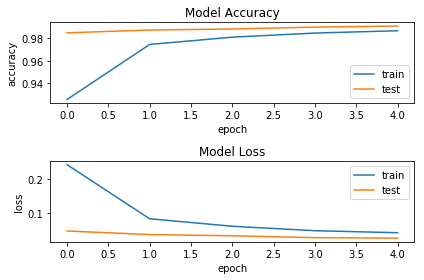

In [16]:
# 准确率，loss值
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

plt.show()

## 保存模型

[model.save()](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

You can use `model.save(filepath)` to save a Keras model into a single **HDF5 file** which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

You can then use `keras.models.load_model(filepath)` to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [17]:
# 保存模型
import os
import tensorflow.gfile as gfile

save_dir = "./mnist/model/"

if gfile.Exists(save_dir):
    gfile.DeleteRecursively(save_dir)
gfile.MakeDirs(save_dir)

model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./mnist/model/keras_mnist.h5 


## 加载模型

In [18]:
# 重新加载模型
from keras.models import load_model

mnist_model = load_model(model_path)

## 统计模型在测试集上的分类结果

In [19]:
# MNIST CNN测试集准确率比MNIST Softmax高，97%->99%，其实还能继续提高
# MNIST Softmax只是简单在像素层面来训练，而MNIST CNN在更高抽象层次上进行训练
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)
    
print("Test Loss: {}".format(loss_and_metrics[0]))
print("Test Accuracy: {}%".format(loss_and_metrics[1]*100))

predicted_classes = mnist_model.predict_classes(X_test)

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print("Classified correctly count: {}".format(len(correct_indices)))
print("Classified incorrectly count: {}".format(len(incorrect_indices)))

Test Loss: 0.027703476275000867
Test Accuracy: 99.08%
Classified correctly count: 9908
Classified incorrectly count: 92
